# W207 Final Project
## Bike Sharing Demand Kaggle Competition
Team Members: Zach Ingbretsen, Nicholas Chen, Keri Wheatley, and Rob Mulla

Kaggle Website Link: https://www.kaggle.com/c/bike-sharing-demand

## Business Understanding

A public bicycle-sharing system is a service in which bicycles are made available for a shared use to individuals on a very short-term basis. A bike-sharing system is comprised of a network of kiosks throughout a city which allows a participant to check-out a bike at one location and return it to a different location. Participants of a bike-sharing system can rent bikes on an as-needed basis and are charged for the duration of rental. Most programs require participants to register as users prior to usage. As of December 2016, roughly 1000 cities worldwide have bike-sharing systems.

Bike-sharing kiosks act as sensor networks for recording customer demand and usage patterns. For each bike rental, data is recorded for departure location, arrival location, duration of travel, and time elapsed. This data has valuable potential to researchers for studying mobility within a city. For this project, we explore customer mobility in relationship to these factors:
1.     Time of day
2.     Day type (workday, weekend, holiday, etc.)
3.     Season (Spring, Summer, Fall, Winter)
4.     Weather (clear, cloudy, rain, fog, snowfall, etc.)
5.     Temperature (actual, “feels like”)
6.     Humidity
7.     Windspeed

This project explores changes in demand given changes in weather and day. Our project delivers an exploratory data analysis as well as a machine-learning model to forecast bike rental demand. Bike rental demand is measured by total rental count which is further broken down into two rental types: rentals by registered users and rentals by non-registered users.  

Kaggle submissions are based on Root Mean Squared Error.

\begin{align}
RMSE & = \sqrt{\frac{1}{2}\sum_{k=1}^n(y_i-\hat{y_1})^2}
\end{align}

## Data Understanding

The data sources for this project are provided by Kaggle. Datasets include train data, test data without results, and an example solution submission.

### Data Features

| Feature    | Description                                                                                                                                                                                                                                                                    |
|------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| datetime   | hourly date + timestamp                                                                                                                                                                                                                                                         |
| season     | **1** = spring, **2** = summer, **3** = fall, **4** = winter                                                                                                                                                                                                                                   |
| holiday    | whether the day is considered a holiday                                                                                                                                                                                                                                        |
| workingday | whether the day is neither a weekend nor holiday                                                                                                                                                                                                                               |
| weather    | **1:** Clear, Few clouds, Partly cloudy, Partly cloudy **2:** Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  **3:** Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  **4:** A Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| temp       | temperature in Celsius                                                                                                                                                                                                                                                         |
| atemp      | "feels like" temperature in Celsius                                                                                                                                                                                                                                            |
| humidity   | relative humidity                                                                                                                                                                                                                                                              |
| windspeed  | wind speed                                                                                                                                                                                                                                                                     |
| casual     | number of non-registered user rentals initiated                                                                                                                                                                                                                                |
| registered | number of registered user rentals initiated                                                                                                                                                                                                                                    |
| count      | number of total rentals                    

## Exploratory Data Analysis

In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import make_scorer
from scipy import stats

# Custom classes for this assignment
#from code import feature_engineering_windspeed_correction as fe
#from code import bikeshare_windspeed_correction as bs

from code import feature_engineering as fe
from code import bikeshare as bs

reload(fe)
reload(bs)


<module 'code.bikeshare' from 'code/bikeshare.pyc'>

In [3]:
# Import our datasets
train_df = pd.read_csv('data/train.csv', index_col=0, infer_datetime_format=True)
train_df.index.name=None # Remove index name to remove confusing datetime column
train_df.index = pd.to_datetime(train_df.index) # Convert index to datetime
test_df = pd.read_csv('data/test.csv', index_col=0, infer_datetime_format=True)
test_df.index.name=None # Remove index name to remove confusing datetime column
test_df.index = pd.to_datetime(test_df.index) # Convert index to datetime

In [4]:
# Describe the numeric features
numeric_features = ['temp','atemp','humidity','windspeed','casual','registered','count']
train_df[numeric_features].describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


The table above shows the characteristics of numeric variables.

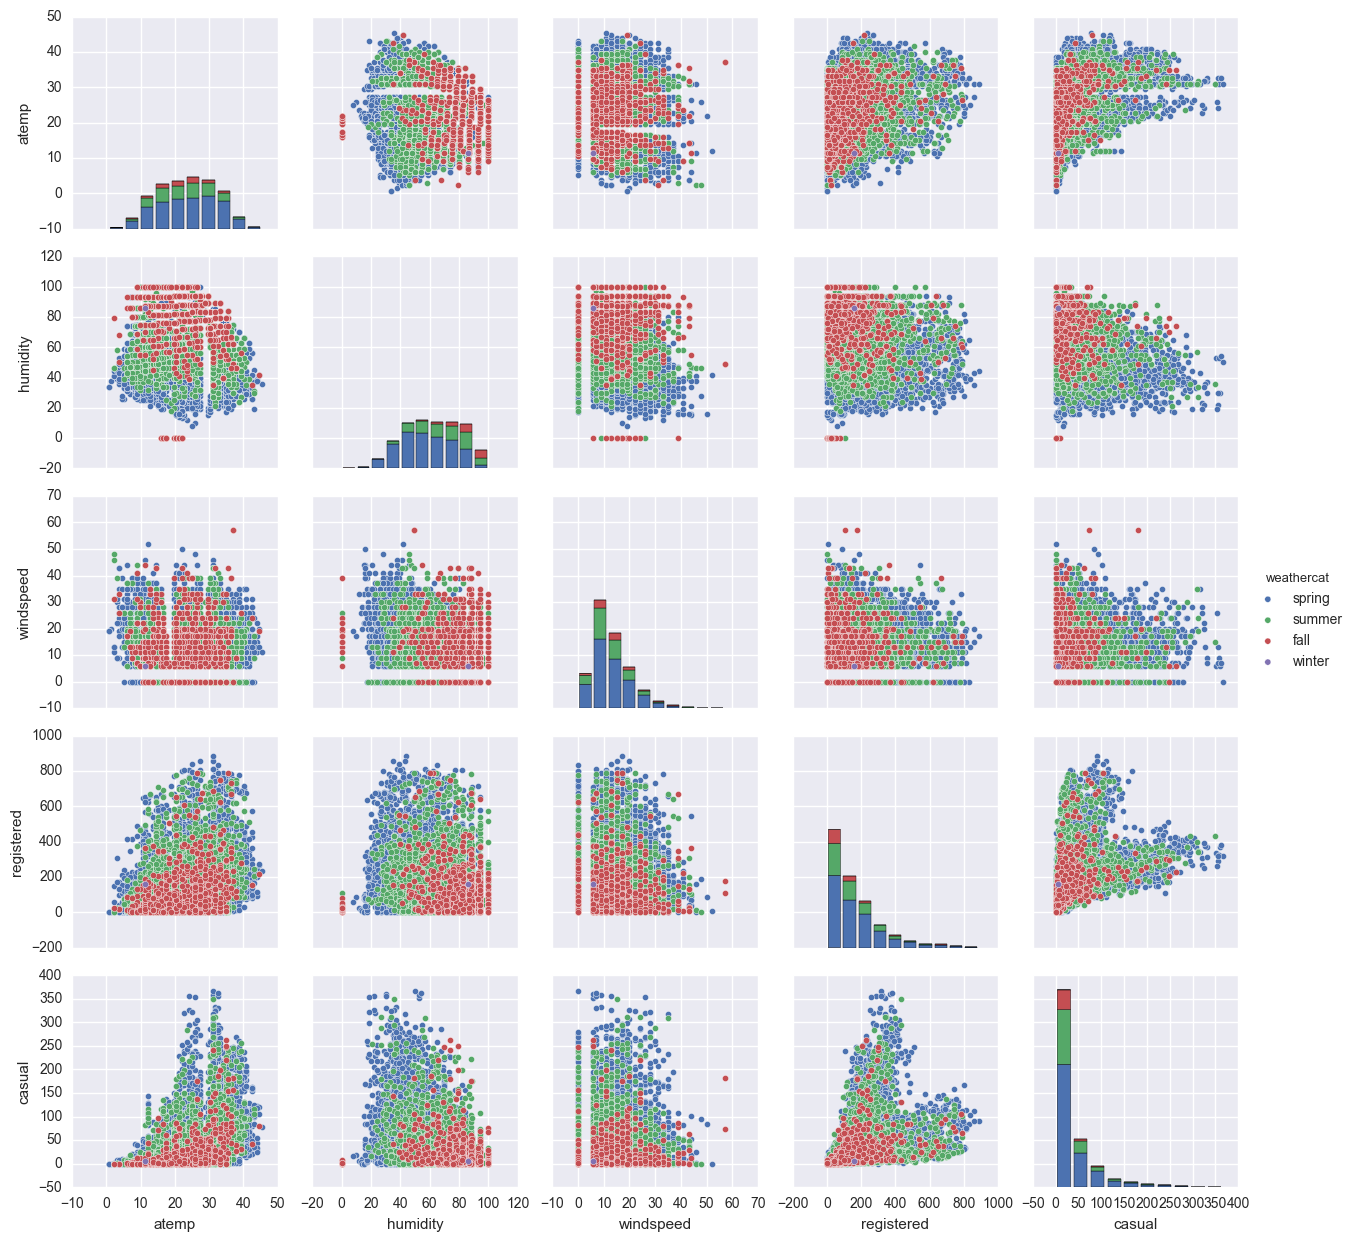

In [9]:
#create a copy of train_df for EDA transformations
train_df_mod = train_df.copy()

# Create a categorical weather column
train_df_mod['weathercat'] = train_df_mod['weather'].astype('category').\
    cat.rename_categories(['spring','summer','fall','winter'])
    
# Scatterplot all variables
scatplot_train = train_df_mod[['atemp','humidity','windspeed','registered','casual','weathercat']]
sns.pairplot(scatplot_train, hue="weathercat");
del train_df_mod['weathercat']

The correlation matrix above shows the relationships between features and resulting counts. 

1. It appears that atemp affects registered rides linearly while atemp has a more exponential relationship with casual rides.

2. It appears that higher humidities (with humidities greater than 50% being more uncomfortable) affects casual rides more than registered rides.

3. There are many instances of 0 value for wind speed and humidity. This may point to a data issue which we address in the modeling section of our project.  

4. Casual ride data has more variability than registered ride data.  

5. Both casual rides and registered rides have long right tails.

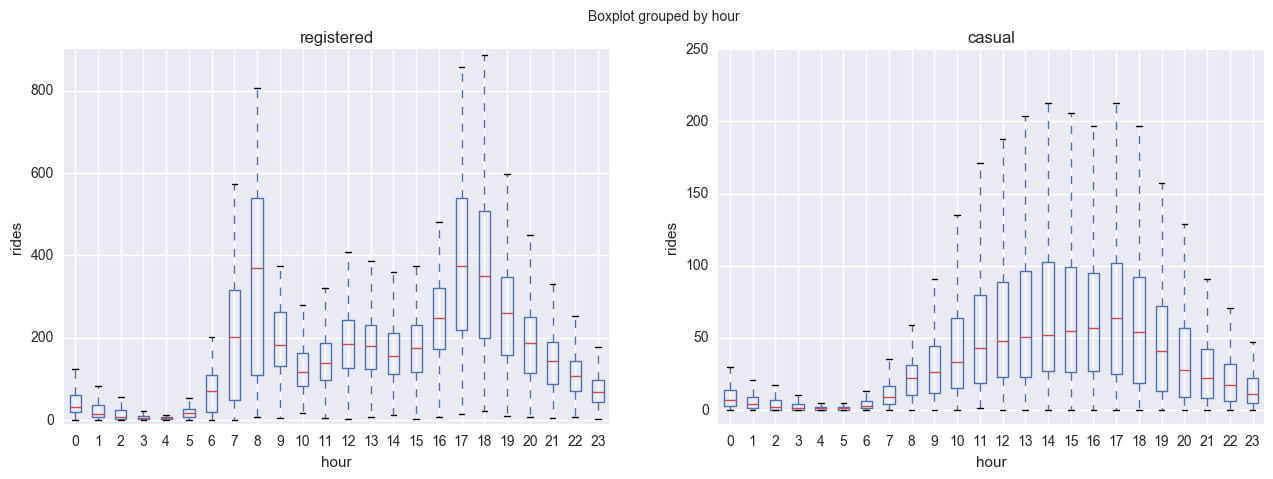

Ks_2sampResult(statistic=0.48668013962888113, pvalue=0.0)

In [10]:
# Create boxplots for registered/casual rides by hour
train_df_mod = bs.eda_transform(train_df_mod)
test = bs.boxplot_by_hour(train_df_mod)

#Add Kolmogrov-Smirnov test to test whether registered and casual rides are drawn from the same distribution
stats.ks_2samp(train_df_mod['casual'], train_df_mod['registered'])

From the boxplots above, it is apparent that there are different distributions throughout the day for registered and casual rides. For registered rides, we see two usage spikes occurring during peak commute times; the first spike occurs between 7-8AM and the second spike occurs between 5-6PM. The casual rides have a fairly normal distribution between 7AM and 11PM. The different distributions of registered and casual rides indicate that we should create two separate models and then combine these models to calculate the final ride count.  

Running a Kolmogrov-Smirnov test to check the null hypothesis that registered and casual rides are drawn from the same distribution yields a p-value of 0.0. This p-value means we can reject the null hypothesis that registered and casual rides are drawn from the same distribution adding support to our conjecture that it is appropriate to fit separate models for registered and casual rides.

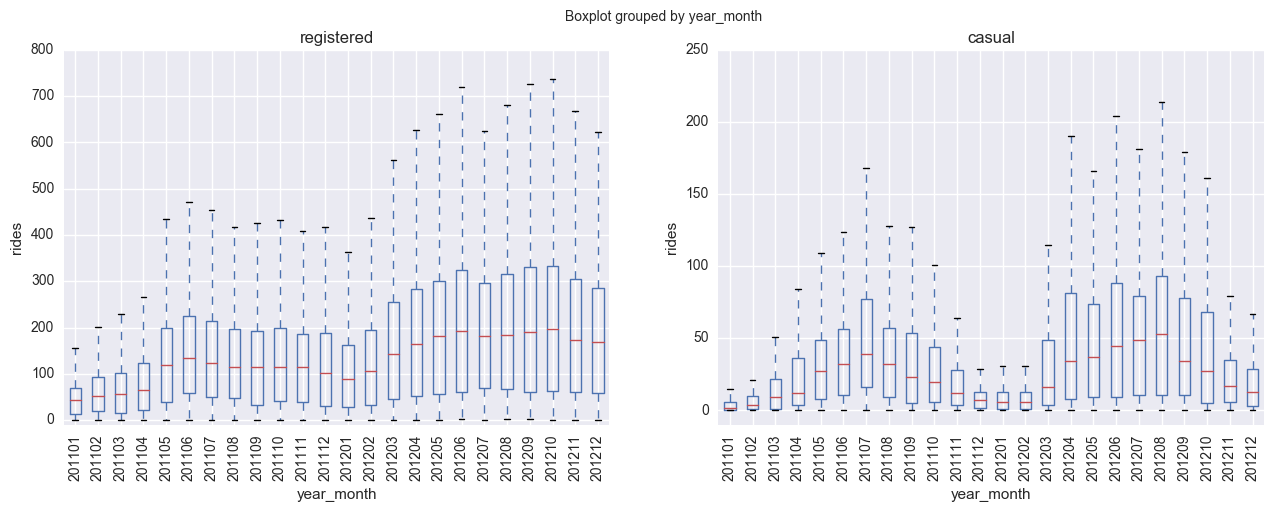

In [11]:
# Create boxplots for registered/casual rides throughout time
bs.boxplot_by_yearmonth(train_df_mod)

The boxplots above show some characteristics of registered and casual rides. Both casual and registered rides show seasonal variability. The seasonal variability is more pronounced for casual rides than registered rides. For registered rides, variation from season to season seems to be strongest, whereas for casual rides, there is a significant variance in rides from month to month. After accounting for seasonality, it is apparent that the total number of rides is increasing over time as more people join the bike sharing program. This indicates that features for season/month and days from inception will be important features for the model. 

## Data Preparation

### Label

We will model the data based on log transformation of the registered and casual labels. We apply a log transformation of the target variables because of the positive skew of both registered and casual rides observed above in the EDA section of our report. This transformation of the target variable was one of the most important adjustments to our model in improving our RMSE score.

In [12]:
# Log transform registered and casual rides
train_df['log_casual'] = np.log(train_df['casual']+1)
train_df['log_registered'] = np.log(train_df['registered']+1)

### Features

Below we define a pipeline to preprocess the feature data using these steps:

In [13]:
# Define steps in pipeline
pipeline = bs.define_pipeline()
print pipeline

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(steps=[('select_cat', SelectCols(cols=('season', 'holiday', 'workingday'), invert=False)), ('onehot', OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_val...          presort='auto', random_state=2, subsample=1.0, verbose=0,
             warm_start=False))])


1. We created new features from datetime (ex. 2011-12-04 12:00:00). Following a series of feature tuning experiments, these features were added to the final model.
        a. hour (ex. 12)  
        b. weekday (ex. 6)
        c. week of the year (ex. 48)    
        d. quarter (ex. 4)    
        e. year (ex. 2012)    
        f. day of the month (ex. 4)
        g. weekend (ex. 1)
2. We then squared the temp, atemp, and humidity features. Increases in these values correlate with increases in the number of casual and registered rides up to a certain upper limit. After that, increases in ride counts taper and then begin to drop. Because of this characteristic, we added the square of these variables to the feature set. [COMMENT Does this make sense? I took this from the idea of adding a square in linear regression.]
        a. temp^2
        b. atemp^2
        c. humidity^2
3. We added the daily max and mean of temp and weather. These transformations were applied because we thought that riders might be more concerned about whether it was a 'warm' day or a 'cold' day in their decision to ride than the actual current temperature.  
        a. daily_max_temp
        b. daily_mean_temp
        c. daily_max_weather
        d. daily_mean_weather
4. In a similar vein, we incorporate features that take into account whether the weather is improving or degrading from hour to hour. Again, the idea of this feature is that a person's decision to ride will be influenced by his outlook on the weather.
        a. weather_getting_better
        b. weather_getting_worse
5. In our initial EDA, there were suspicious concentrations of zero windspeed values. We have replaced these values with their nearest non-zero neighbors.
        a. non_zero_windspeed
6. We removed datetime from the feature set because the values in are too granular and are already covered in the derived features above.

### Split for Train and Development Data

We will split the train data into a train and dev dataset. Since the Kaggle data is being tested on days 21-30, we will follow the same method and split train and dev by 1-16 day of month and 17-19 day of month.

In [14]:
# Split the data into train data and a dev data based on day of the month.
train_data = train_df[train_df.index.day <= 16]
dev_data = train_df[train_df.index.day > 16]

## Modeling

### Scoring
Before we begin modelling, we define a custom scorer for RSME as defined above.

In [15]:
# Define RMSE scorer
RMSE_scorer = make_scorer(bs.get_RMSE, greater_is_better = False)

### Model

Based on testing outside of this final write-up, we decided to use GradientBoost as the basis for our model. GradientBoost is an ensemble learning method which combines weak learning decision trees (high bias, low variance) to form a random forest. 

### Parameter Tuning with Gridsearch

We will run parameter tuning on the data to find the best parameters. These are the relevant parameters for GradientBoost as defined by Sklearn. The charts below show how RMSE is impacted by manipulating each of these parameters in isolation.

1. n_estimators: 
        The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

2. learning_rate: 
        Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
3. max_depth: 
        Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.
4. min_samples_leaf:
        The minimum number of samples required to split an internal node.

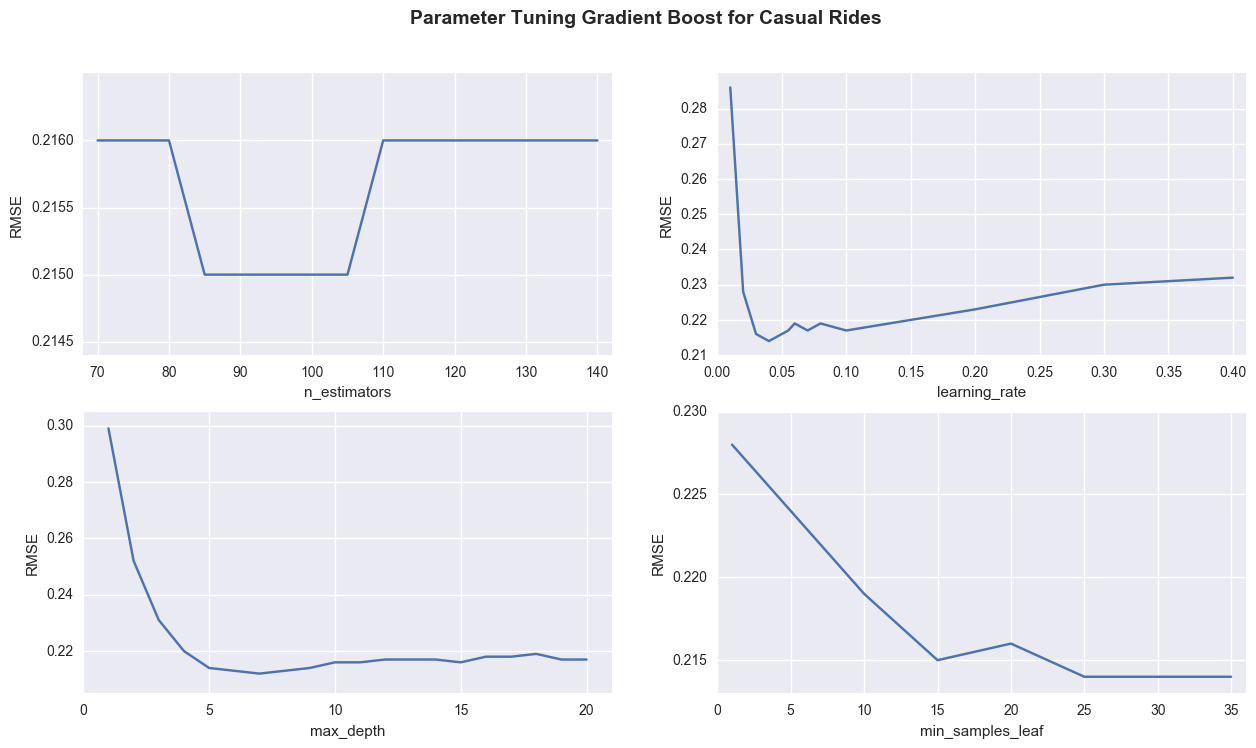

In [16]:
bs.param_tuning_graphs_abbrev_casual()

Using the gridsearch package, we tested dozens of models to find the best parameters for registered rides and for casual rides. Iterating through these parameters took many days of processing. Below are the parameters tested for tuning.

    n_estimators=[70,75,80,85,90,95,100,105,110,115,120,125,130,135,140]
    learning_rate=[.01,.02,.03,.04,.045,.05,.055,.06,.07,.08,.09,.1,.2,.3,.4]
    max_depth=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    min_samples_leaf=[1,5,10,15,20,25,30,35]

The parameter tuning resulted in these best parameters:

    n_estimators=115
    learning_rate=0.05
    max_depth=10
    min_samples_leaf=20

## Evaluation

The code below creates predictions using the models defined above for registered and casual rides. 

In [19]:
features = [c for c in train_df.columns if c not in ['count', 'casual', 'registered', 'log_casual', 'log_registered']]

# Create full model using all train data
full_casual_gs = pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 3,
        union__numerical__daily_max__cols = ['weather'],
        union__numerical__daily_mean__cols = ['weather','temp'],
    )
full_casual_gs.fit(train_df[features], train_df['log_casual'])
full_casual_predicted_y_log = full_casual_gs.predict(test_df[features])
# np.exp converts back from log
full_casual_predicted_y = np.exp(full_casual_predicted_y_log)-1

full_registered_gs = pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 4,
        union__numerical__daily_max__cols = None,
        union__numerical__daily_mean__cols = ['weather'],
)
full_registered_gs.fit(train_df[features], train_df['log_registered'])
full_registered_predicted_y_log = full_registered_gs.predict(test_df[features])
# np.exp converts back from log
full_registered_predicted_y = np.exp(full_registered_predicted_y_log)-1

ValueError: Invalid parameter daily_mean for estimator Pipeline(steps=[('select_num', SelectCols(cols=('datetime', 'weather', 'temp', 'atemp', 'humidity', 'windspeed'),
      invert=False)), ('date', DateFormatter()), ('drop_datetime', SelectCols(cols=('datetime', 'month'), invert=True)), ('temp', ProcessNumerical(cols_to_log=(), cols_to_sqrt=(),
         cols_t...WindspeedAdjustment(use=True)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]). Check the list of available parameters with `estimator.get_params().keys()`.

## Deployment

The below code outputs a CSV file to the 'data' folder. This output contains datetime and predicted ride count and is ready for submission to the Kaggle website.

In [341]:
test_df['count'] = (np.array([full_casual_predicted_y>0]*full_casual_predicted_y)).T+\
    (np.array([full_registered_predicted_y>0]*full_registered_predicted_y)).T
test_df.index.names = ['datetime']
test_df[['count']].to_csv('data/combined_preds.csv')